In [2]:
from shapely import Polygon

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import skimage.data as data
import skimage.segmentation as seg
from skimage.segmentation import mark_boundaries
import skimage.measure as meas

import imageio.v3 as iio
import shapely.plotting as splt
import networkx as nx


In [4]:
PATH = 'plans/fp02.png'
metadata = iio.immeta(PATH)
print(metadata)
# fp01 = imageio.v3.imread('plans/fp01.png', pilmode='RGB')
# fp01 = iio.imread(PATH)
fp01 = iio.imread(PATH, pilmode='RGB')

{'dpi': (72.009, 72.009), 'srgb': 0, 'gamma': 0.45455, 'mode': 'RGBA', 'shape': (258, 82)}


In [5]:
fp01.shape

(82, 258, 3)

In [6]:
fp01[0].shape

(258, 3)

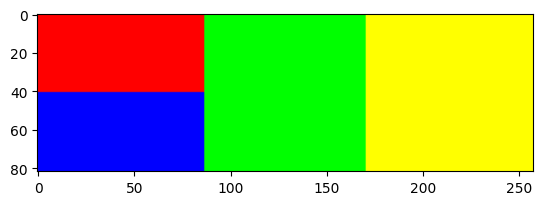

In [7]:
plt.imshow(fp01)

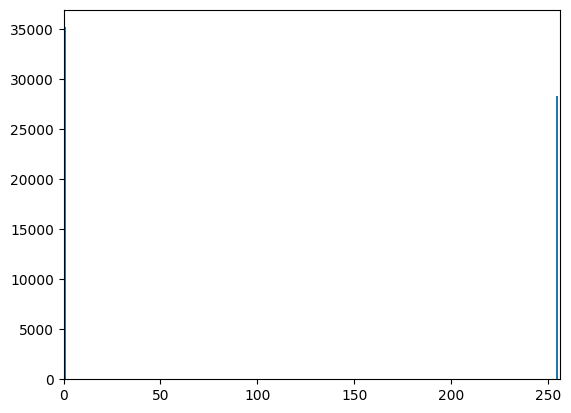

In [8]:
fig, ax = plt.subplots(1, 1)
ax.hist(fp01.ravel(), bins=256, range=[0, 255])
ax.set_xlim(0, 256);
# very discrete locations which is good -> potentially very clear 

In [9]:
fp01.shape

(82, 258, 3)

### SLIC algorithm

In [10]:
# try unsupervised segmentation 
fp01_slic = seg.slic(fp01, n_segments=4, channel_axis=2)
fp01_slic

array([[1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       ...,
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3]])

In [11]:
np.unique(fp01_slic)

array([1, 2, 3])

In [12]:
meas.regionprops_table(fp01_slic)

{'label': array([1, 2, 3]),
 'bbox-0': array([0, 0, 0]),
 'bbox-1': array([  0,  87, 171]),
 'bbox-2': array([82, 82, 82]),
 'bbox-3': array([ 87, 171, 258])}

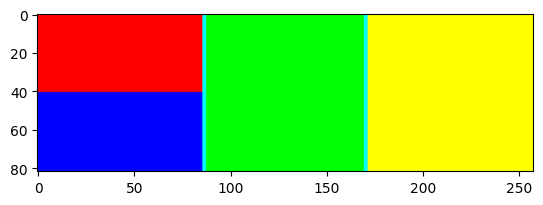

In [13]:
border_color = [0,1,1]
plt.imshow(mark_boundaries(fp01, fp01_slic, color=border_color))

### Other algorithms

In [14]:
fp01_qs = seg.quickshift(fp01, max_dist=100)
np.unique(fp01_qs)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [15]:
fp01_fel = seg.felzenszwalb(fp01, min_size=300, channel_axis=2)
np.unique(fp01_fel)

array([0, 1, 2, 3])

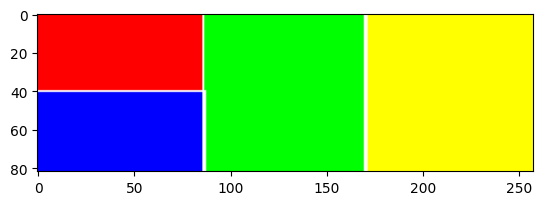

In [16]:
border_color = [1,1,1]
plt.imshow(mark_boundaries(fp01, fp01_fel, color=border_color))

In [17]:
meas.regionprops_table(fp01_fel)

{'label': array([1, 2, 3]),
 'bbox-0': array([ 0,  0, 41]),
 'bbox-1': array([ 87, 171,   0]),
 'bbox-2': array([82, 82, 82]),
 'bbox-3': array([171, 258,  87])}

In [18]:
p = meas.regionprops(fp01_fel)

In [19]:
p[0].bbox

(0, 87, 82, 171)

In [20]:
p[1].bbox

(0, 171, 82, 258)

## Astronaut example

In [21]:
astronaut = data.astronaut()
# image_show(astronaut);

In [22]:
astronaut.shape

(512, 512, 3)

In [23]:
astronaut_slic = seg.slic(astronaut)
image_show(color.label2rgb(astronaut_slic, astronaut, kind='avg'));

NameError: name 'image_show' is not defined

## Shapely 

In [ ]:
class Bbox():
    def __init__(self, arr):
        assert len(arr) == 4
        self.min_row=arr[0]
        self.min_col=arr[1]
        self.max_row=arr[2]
        self.max_col=arr[3]

In [ ]:
b1 = Bbox(p[1].bbox)
b1.max_col

258

In [ ]:
# def create_coords(b:Bbox): 
#     # clockwise from origin in bottom-left corner to match example: 
#     # https://shapely.readthedocs.io/en/stable/reference/shapely.LinearRing.html#shapely.LinearRing
#     coords = [
#         (b.min_row, b.min_col),
#         (b.max_row, b.min_col),
#         (b.max_row, b.max_col),
#         (b.min_row, b.max_col),
#     ]
#     return coords

In [ ]:
def create_coords(b:Bbox): 
    # clockwise from origin in bottom-left corner to match example: 
    # https://shapely.readthedocs.io/en/stable/reference/shapely.LinearRing.html#shapely.LinearRing
    coords = [
        # col ==> x, row ==> y 
        (b.min_col, b.min_row),
        (b.max_col, b.min_row),
        (b.max_col, b.max_row),
        (b.min_col, b.max_row),
    ]
    return coords

In [ ]:
# TODO make class for regions 

class Region():
    def __init__(self):
        self.bbox:list = None
        self.coords:list = None
        self.shape:Polygon = None
        self.centroid:tuple = None



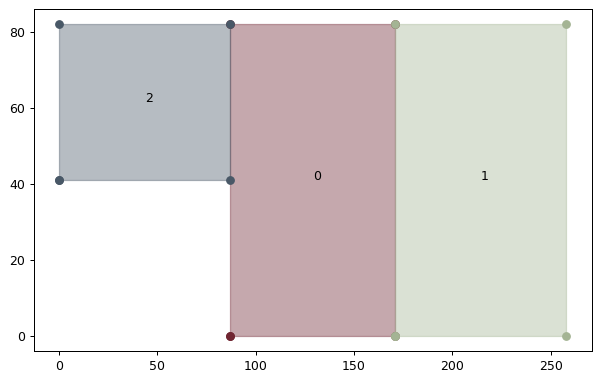

In [ ]:
GM = (np.sqrt(5)-1.0)/2.0
W = 8
H = W*GM
SIZE = (W, H)

fig = plt.figure(figsize=SIZE,  dpi=90)
ax = fig.add_subplot(111)

reg_d = {}
colorway = ['#702632', '#A4B494', '#495867', '#912F40', "#81909E", "#F4442E", "#DB7C26", "#BB9BB0"]

props = meas.regionprops(fp01_fel)

for ix, p in enumerate(props): 
    reg_d[ix] = {}
    reg_d[ix]["bbox"] = p.bbox
    
    coords = create_coords(Bbox(p.bbox))
    reg_d[ix]["coords"] = coords
    reg_d[ix]["shape"] = Polygon(coords)
    reg_d[ix]["centroid"] = (reg_d[ix]["shape"].centroid.x, reg_d[ix]["shape"].centroid.y)

    splt.plot_polygon(reg_d[ix]["shape"], ax=ax, alpha=0.4, color=colorway[ix])
    ax.annotate(str(ix), reg_d[ix]["centroid"])

In [ ]:
reg_d[0]

{'bbox': (0, 87, 82, 171),
 'coords': [(87, 0), (171, 0), (171, 82), (87, 82)],
 'shape': <POLYGON ((87 0, 171 0, 171 82, 87 82, 87 0))>,
 'centroid': (129.0, 41.0)}

In [ ]:
def check_adjacency(curr_node_ix:int, nb_node_ix:int):
    # shapely check for adjacency 
    check = reg_d[curr_node_ix]["shape"].touches(reg_d[nb_node_ix]["shape"])
    return int(check) # True = 1, False = 0

## create adjacency graph

In [ ]:
def draw_graph(self):
    pos = nx.spring_layout(self.CG)
    nx.draw_networkx_nodes(self.CG, pos)
    nx.draw_networkx_edges(self.CG, pos, )
    nx.draw_networkx_labels(self.CG, pos)
    self.CG_edge_labels = nx.draw_networkx_edge_labels(self.CG, pos)
    return plt

    # plt.show()

In [ ]:
def draw_graph(CG):
    pos = nx.spring_layout(CG)
    nx.draw_networkx_nodes(CG, pos)
    nx.draw_networkx_edges(CG, pos, )
    nx.draw_networkx_labels(CG, pos)
    k = nx.draw_networkx_edge_labels(CG, pos, )
    return plt

    # plt.show()

<module 'matplotlib.pyplot' from '/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/gqenv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

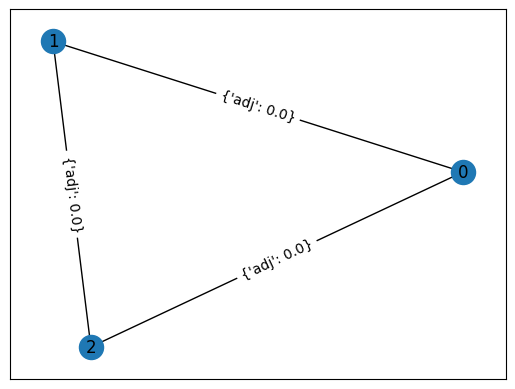

In [ ]:
# initialize fully connected graph with edge adjacency init to 0 
n_nodes = 3 #TODO get infor from image segmentaion part.. 
CG = nx.complete_graph(n_nodes)  

# set edge properties -> 0 = all unconnected to begin 
init_adj = np.zeros((n_nodes, n_nodes))

# need to have labels / indices for the edge properties that explicitly index into the matrix 
n = np.linspace(0,n_nodes-1,n_nodes)
X2D,Y2D = np.meshgrid(n,n)
X2D, Y2D
attrs = {(x,y): {"adj": i, } for x,y,i in zip(Y2D.ravel(),X2D.ravel(), init_adj.ravel())}
attrs
nx.set_edge_attributes(CG, attrs)
draw_graph(CG)

In [ ]:
def check_adjacency(curr_region:Region.shape, nb_region:Region.shape):
    # shapely check for adjacency 
    check = curr_region.touches(nb_region)
    return int(check) # True = 1, False = 0

<module 'matplotlib.pyplot' from '/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/gqenv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

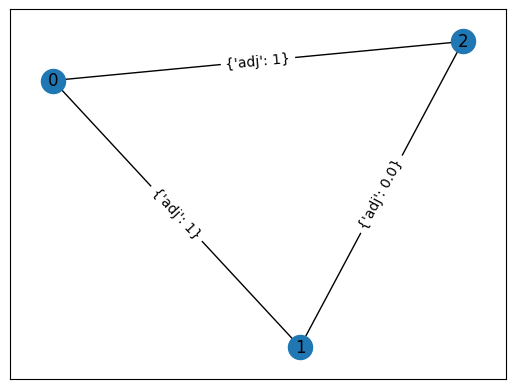

In [ ]:
# check adjacency based on shapely connections
for n in CG.nodes:
    neighbors = list(nx.bfs_edges(CG, source=0, depth_limit=1))
    for pair in neighbors:
        if CG.edges[pair]["adj"] == 0:
            adj_val = check_adjacency(pair[0], pair[1])
            CG.edges[pair]["adj"] = adj_val

draw_graph(CG)

In [ ]:
for e in self.CG.edges:
    if self.CG.edges[e]["adj"] == 0:
        self.CG.remove_edge(*e)

<module 'matplotlib.pyplot' from '/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/gqenv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

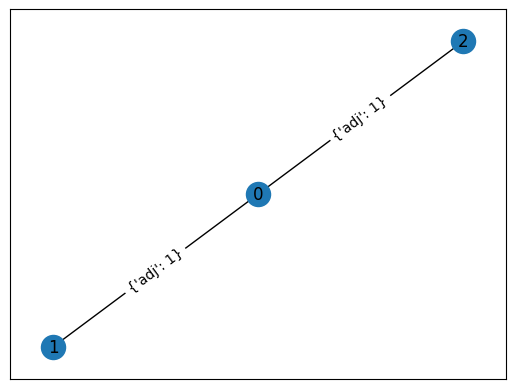

In [ ]:
# remove edges where adjacency is 0
for e in CG.edges:
    if CG.edges[e]["adj"] == 0:
        CG.remove_edge(*e)

draw_graph(CG)